<a href="https://colab.research.google.com/github/luceroster/TaurisTest/blob/master/Trabajo_Final_CNN_Pablo_Lucero_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [33]:
# Imagen para estilo
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido

!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
!mkdir /content/output

--2020-06-30 01:06:19--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg.2’

La_noche_estrellada 100%[===================>] 218.48K  --.-KB/s    in 0.02s   

2020-06-30 01:06:19 (12.5 MB/s) - ‘La_noche_estrellada1.jpg.2’ saved [223725/223725]

--2020-06-30 01:06:21--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153015 (149K) 

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

In [36]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path("/content/775px-Neckarfront_Tübingen_Mai_2017.jpg")
#base_image_path = Path("/content/zfmly.jpg")
style_reference_image_path = Path("/content/La_noche_estrellada1.jpg")
#style_reference_image_path = Path("/content/zpicasso.jpg")
result_prefix = Path("/content/output")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

**Respuesta**: Son los pesos seleccionados para content y style. Son los pesos de la ecuacion (7) del paper mencionado arriba. En la siguiente formula seria el alfa para Content y el beta para style.
- El content_weight = alfa
- Style_weight = beta
- total_variation_weight = peso para el calculo de la loss que penaliza la varianza de la imagen generada dandole coherencia y suavidad en los cambios entre pixeles 
 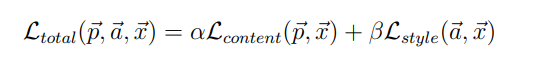 


In [55]:
total_variation_weight = 0.1
style_weight = 1
content_weight = 10

In [56]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

**Respuesta**: La celda contiene una funcion que carga la imagen y la redimensiona para adecuarla al modelo de la red elegida, en este caso la VGG19. Las ultimas dos lineas hacen lo siguiente: 
"expand_dim", funcion de numpy que toma la imagen y expande el array en 1 dimension para poder procesar en batch.
 "vgg19.preprocess_input(img)" toma la imagen y la adecua a los requerimientos del modelo. En algunos ejemplos posteados el rezising es entre -1, 1 (ResNet50).  En este caso sera lo que vgg19 requiera. Cambia de RGB -> BGR (documentacion vgg16 preprocess tensorflow)


In [57]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

**Respuesta**: Convierte el array generado anteriomente en una imagen valida para su uso mas adelante. Descentra la imagen y la convierte en RGB. Se relaciona con la celda anterior ya que el array es generado en dicha celda y esta funcion retorna el formato de la imagen cambiado en la celda anterior.

In [58]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [59]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [60]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [61]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [62]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram? 
- R: Gram matrix se usa para estimar la relacion entre los filtros de los diferentes layers usados. Es el producto punto entre filtros para al final calcular la correlacion entre ellos. 
-¿Para qué se usa? 
- R: Para calcular el style loss

- ¿Por qué se permutan las dimensiones de x?
- R: Porque es la manera computacional de ejecutar la Gram Matrix y encontrar aquellos features que se activan simultaneamente en una misma posicion. Primero se permuta para que de bien luego al transponer. 
- Fuente https://towardsdatascience.com/artistic-style-transfer-b7566a216431


In [63]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta:
- 1: Style Loss: Consiste en una suma de distancias L2 entre la matriz Gram de la representacion de la imagen base y la referencia de la imagen de estilo, extraida de diferentes layers de una convnet. La idea es capturar informacion de color/textura a diferentes escalas espaciales, definidas por la profundidad del layer considerado.
- 2: Content loss: Es la distancia L2 cuadratica media entre la imagen base content (extraida de un deep layer) y la imagen combinada, manteniendo la imagen generada lo suficientemente cerca de la imagen original. 

- 3: Total variation loss: Mide la transicion entre pixeles de la imagen generada y promueve una transicion suave entre ellos. Esta diseniada para mantener la imagen generada localmente coherente y mantener una continuidad espacial.
- Fuente de estudio: https://www.youtube.com/watch?v=pvjkwmRyFeo


In [64]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [65]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [66]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [67]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [68]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta: 
- La primer celda: Es una funcion de evaluacion de loss y el gadiente de la loss de la imagen generada (grads), haciendo resizing y usando la funcion de las celdas anteriores (f_outputs)
- La segunda celda es una clase que sera usada en la celda posterior, esta clase llamada evaluator() adapta los datos ya que el optimizador utilizado luego, L-BFGS de scipy no es como los maneja keras.
- La terera celda es el loop del optimizador. Se itera n veces (100 para este caso) y termina. Por cada loop se deprocesa la imagen, o sea que se corre el cero y se vuelven a invertir los colores BGR ->RGB y se guarda como nueva imagen generada. 
- El paper solo usa las loss de style y content, mientras el ejemplo que estamos viendo usa ademas el total loss.
- Un metodo alternativo de optimizador puede ser gradient descent (SGD).

Fuente de estudio:https://www.youtube.com/watch?v=8D5x9dRQ5cM


In [69]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [70]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [71]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 4397544400.0
Image saved as /content/output/output_at_iteration_0.png
Iteration 0 completed in 4s
Start of iteration 1
Current loss value: 2653032400.0
Image saved as /content/output/output_at_iteration_1.png
Iteration 1 completed in 4s
Start of iteration 2
Current loss value: 2120870400.0
Image saved as /content/output/output_at_iteration_2.png
Iteration 2 completed in 4s
Start of iteration 3
Current loss value: 1861674000.0
Image saved as /content/output/output_at_iteration_3.png
Iteration 3 completed in 4s
Start of iteration 4
Current loss value: 1696511400.0
Image saved as /content/output/output_at_iteration_4.png
Iteration 4 completed in 4s
Start of iteration 5
Current loss value: 1593086200.0
Image saved as /content/output/output_at_iteration_5.png
Iteration 5 completed in 4s
Start of iteration 6
Current loss value: 1519438300.0
Image saved as /content/output/output_at_iteration_6.png
Iteration 6 completed in 4s
Start of iteration 7
Curren

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:
Se probo con los pesos originales style weight=10 content_weight=1 y luego se revirtio el peso siendo content_w=10 y style_w=1. Se observa que al darle mas peso al content se pierden menos detalles de la foto original. Los cambios se dan en las primeras iteraciones y luego se estabiliza. Por ello adjunto todas las fotos de las iteraciones 1 a 10 y luego adjunto 1 cada 10 iteraciones.


# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta: Adjuntas - Foto de familia tomada con paisaje de fondo para content y cuadro de picasso como style. Incluidos en el mismo adjunto.